In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark/detection/detector_eval')

In [3]:
import json
import os
from collections import defaultdict

import numpy as np
from detection.detector_eval import detector_eval
from data_management import cct_json_utils
from visualization.visualization_utils import plot_precision_recall_curve

In [4]:
detection_results_dir = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904'
results_path = [os.path.join(detection_results_dir, f) for f in os.listdir(detection_results_dir)]

In [5]:
results_path

['/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/5618_detections_train_cct_20_val_ss1_20190908093215.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/5618_detections_train_cct_20_val_ss1_20190908093215_noprefix.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/6704_detections_train_ss1_val_cct20_20190908092921.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/8506_detections_train_cct_20_val_cct20_20190908093026.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/948_detections_train_ss1_val_ss1_20190908092426.json']

In [6]:
num_gt_classes = 2

Ground truth: `[x, y, width, height]`
    
API output: `[x_min, y_min, width_of_box, height_of_box]`

TF format: `[y_min, x_min, y_max, x_max]`

In [9]:
def show_metrics(per_cat_metrics):
    for cat, metrics in per_cat_metrics.items():
        print('\n' + str(cat))
        print('Number of gt:', metrics['num_gt'])
        print('Average precision', metrics['average_precision'])

    mAP_from_cats = detector_eval.find_mAP(per_cat_metrics)
    print('\nmAP as the average of AP across the {} categories is {:.4f}'.format(num_gt_classes, mAP_from_cats))

    precision_at_08_recall = detector_eval.find_precision_at_recall(per_cat_metrics[1]['precision'], per_cat_metrics[1]['recall'], 
                                                                    per_cat_metrics[1]['scores'],
                                                                    recall_level=0.8)
    print('Precision at 0.8 recall:', precision_at_08_recall)
    
    plot_precision_recall_curve(per_cat_metrics[1]['precision'], per_cat_metrics[1]['recall'], title='bbox level')

In [11]:
empty_threshold = 0.5

# Train on SS S1, val on SS S1

## bbox

  5%|▌         | 151/2843 [00:00<00:01, 1508.80it/s]

Running per-object analysis...


100%|██████████| 2843/2843 [00:01<00:00, 1528.92it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 4371
Number of ground truth in category 2 is 7

one_class
Number of gt: 4378
Average precision 0.814277886637954

1
Number of gt: 4371
Average precision 0.8155819235188658

2
Number of gt: 7
Average precision 0.0

mAP as the average of AP across the 2 categories is 0.4078
Precision at 0.8 recall: (0.8925472179683512, 0.9179999828338623)


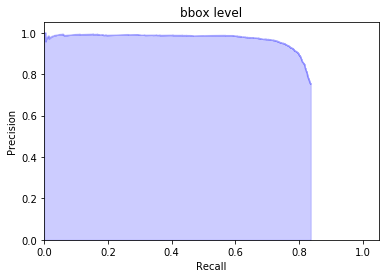

In [10]:
file_prefix = 'SER/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/948_detections_train_ss1_val_ss1_20190908092426.json'

gt_db_path = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiBboxesS01_20190903_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

## empty vs non-empty

In [12]:
accuracy = detector_eval.compute_emptiness_accuracy(gt_indexed, detection_res, threshold=empty_threshold)

print('Accuracy:', accuracy)

Accuracy: 0.9785689595575527


# Train on SS S1, val on CCT-20

## bbox

  1%|          | 159/18202 [00:00<00:11, 1588.30it/s]

Running per-object analysis...


100%|██████████| 18202/18202 [00:11<00:00, 1596.97it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18113
Number of ground truth in category 2 is 0

one_class
Number of gt: 18113
Average precision 0.713500230159196

1
Number of gt: 18113
Average precision 0.7130783511904878

2
Number of gt: 0
Average precision nan

mAP as the average of AP across the 2 categories is 0.3565
Precision at 0.8 recall: (0.47243504058944347, 1.0)


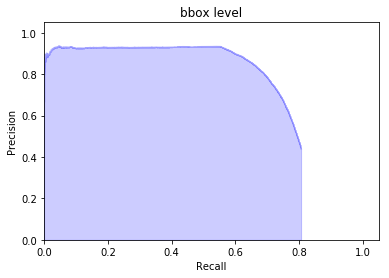

In [13]:
file_prefix = 'cct_images/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/6704_detections_train_ss1_val_cct20_20190908092921.json'

gt_db_path = '/beaver_disk/camtrap/caltech/benchmark/cct-20/caltech-20_bboxes_20190904_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

## empty vs non-empty

In [14]:
accuracy = detector_eval.compute_emptiness_accuracy(gt_indexed, detection_res, threshold=empty_threshold)

print('Accuracy:', accuracy)

Accuracy: 0.9071859347848308


# Train on CCT-20, val on CCT-20

## bbox

  1%|          | 162/17918 [00:00<00:10, 1615.02it/s]

Running per-object analysis...


100%|██████████| 17918/17918 [00:11<00:00, 1617.58it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18539
Number of ground truth in category 2 is 0

one_class
Number of gt: 18539
Average precision 0.9346375483403553

1
Number of gt: 18539
Average precision 0.9348238623588044

2
Number of gt: 0
Average precision nan

mAP as the average of AP across the 2 categories is 0.4674
Precision at 0.8 recall: (0.9758536745838542, 0.9990000128746033)


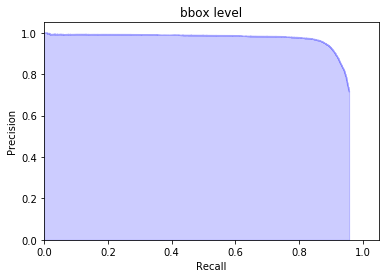

In [17]:
file_prefix = 'cct_images/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/8506_detections_train_cct_20_val_cct20_20190908093026.json'

gt_db_path = '/beaver_disk/camtrap/caltech/benchmark/cct-20/caltech-20_bboxes_20190904_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

## empty vs non-empty

In [18]:
accuracy = detector_eval.compute_emptiness_accuracy(gt_indexed, detection_res, threshold=empty_threshold)

print('Accuracy:', accuracy)

Accuracy: 0.9010528467750178


# Train on CCT-20, val on SS S1

## bbox

  6%|▌         | 157/2725 [00:00<00:01, 1562.08it/s]

Running per-object analysis...


100%|██████████| 2725/2725 [00:01<00:00, 1574.81it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 4208
Number of ground truth in category 2 is 7

one_class
Number of gt: 4215
Average precision 0.7444823251535193

1
Number of gt: 4208
Average precision 0.7457207700860465

2
Number of gt: 7
Average precision 0.0

mAP as the average of AP across the 2 categories is 0.3729
Precision at 0.8 recall: (0.0, 0.9990000128746033)


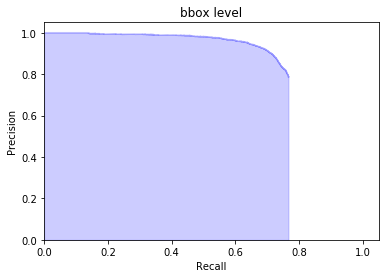

In [19]:
file_prefix = 'SER/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/5618_detections_train_cct_20_val_ss1_20190908093215.json'

gt_db_path = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiBboxesS01_20190903_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

## empty vs non-empty

In [20]:
accuracy = detector_eval.compute_emptiness_accuracy(gt_indexed, detection_res, threshold=empty_threshold)

print('Accuracy:', accuracy)

Accuracy: 0.9232630487383339
